# Time series modeling of COVID-19 data in Colorado

This code generates a plot of 7-day averages of case counts and death counts for each county in Colorado over time, plus a 24-day forecast using a time series model. For forecasting, I used a form of an [autoregressive integrated moving average (ARIMA) model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average). I didn't love the Python implementations of ARIMA that I found when teaching last year, so this time around I wanted to implement something myself, using  [*scikit-learn*](https://scikit-learn.org) for fitting the regression models.

By itself, this is a pretty simple type of model that only uses the counts themselves to make variables for predicting counts in the future. These forecasts haven't been validated and shouldn't be taken too seriously. It's more like, "here's what could happen if things continue the way they've been going." I made this because I think it's fun, and am sharing as a demonstration of how to put something like this together.

### Colorado case data

The [Colorado case data](https://covid19.colorado.gov/data/case-data) can be found in this [Google folder](https://drive.google.com/drive/folders/1bBAC7H-pdEDgPxRuU_eR36ghzc0HWNf1) that is updated daily. There is a CSV file for each day, which includes data for each county. Specifically, it includes positive cases, deaths, and testing counts/rates. Hospitalization numbers are only provided at the state level instead of the county level; I use the state-level hospitalization value as a variable in the models but do not model it itself because it's not available for specific counties. (Hospitalization data is available within geographic regions in a [separate folder](https://drive.google.com/drive/folders/1bjQ7LnhU8pBR3Ly63341bCULHFqc7pMw), but the regions are coarser-grained than counties, and I haven't been able to figure out which counties are included in which region.)

The CSV format changes a little bit over time, so my code has a few rules based on the date of the file. The different checks and messages will hopefully make it easier to spot if there is a problem with data in the future. The case counts in these files are *cumulative* counts (i.e., the total number of cases to date), which I convert into daily counts in a later code cell.

If you wanted to modify this project to work on data from a different location than Colorado, this is the main block of code that you'll need to edit.

In [1]:
import pandas as pd
import os
import logging

def validate_county(county, day):
    if not county:
        raise ValueError('Blank county value')
    if 'pending' in county.lower() or 'unknown' in county.lower():
        raise ValueError('County is listed as "Pending" or "Unknown"')
    if 'total' in county.lower() or 'international' in county.lower():
        raise ValueError('Not a valid county')
    if (day >= '2020-03-25' and day < '2020-04-28') and county.split()[-1] != 'County':
        raise ValueError('County does not end in "County"')
    
    if county.split()[-1] == 'County':
        county = ' '.join(county.split()[:-1]) # remove trailing "County" if present
    
    return county

def validate_counts(count):
    try:
        count = int(count)
    except:
        raise ValueError('Case count not recognized as integer')
    
    if count < 0 or count > 1e6:
        raise ValueError('Case count outside of valid bounds')

    return count


case_counts = {}
death_counts = {}
hospitalizations = {}
counties = set()
final_date = ''

for filename in sorted(os.listdir('Case_data')):
    if os.path.splitext(filename)[-1] != '.csv': continue
        
    date_str = os.path.splitext(filename)[-2].split('_')[-1]
    case_counts[date_str] = {}
    death_counts[date_str] = {}
    final_date = date_str

    logging.info('Processing:', filename)
    filename = os.path.join('Case_data', filename) 
    df = pd.read_csv(filename, header=0, dtype=str)
    
    # cases (county level)
    
    description = 'Case Counts by County'
    if date_str >= '2020-04-22':
        description = 'Colorado Case Counts by County'
    rows = df.loc[(df['description'] == description) & (df['metric'] == 'Cases')]
    
    for index, row in rows.iterrows():
        try:
            county = validate_county(row['attribute'].strip(), date_str)
            daily_count = validate_counts(row['value'])
            
            counties.add(county)
            case_counts[date_str][county] = daily_count

        except ValueError as msg:
            warning_msg = '%s (%s)' % (msg, filename)
            logging.warning(warning_msg)
    
    # deaths (county level)
    
    description = 'Deaths'
    metric = 'Cases'
    if date_str >= '2020-04-22':
        description = 'Number of Deaths by County'
        metric = 'Deaths'
    rows = df.loc[(df['description'] == description) & (df['metric'] == metric)]
    
    for index, row in rows.iterrows():
        try:
            county = validate_county(row['attribute'].strip(), date_str)
            daily_count = validate_counts(row['value'])
            
            death_counts[date_str][county] = daily_count

        except ValueError as msg:
            warning_msg = '%s (%s)' % (msg, filename)
            logging.warning(warning_msg)

    # hospitalizations (state level)
    
    rows = df.loc[(df['attribute'] == 'Statewide') & (df['metric'] == 'Hospitalizations')]
    try:
        count = validate_counts(rows.iloc[0]['value'])
    except:
        count = 0
        
    hospitalizations[date_str] = count
    

### Transform and segment data

The first thing I do is convert the raw time series into a sequence of rolling averages. Colorado usually uses 5-day averages in their reporting, but I prefer 7-day averages because this  eliminates "day-of-week" effects (e.g., fewer cases reported on weekends).

A separate decision to make is the unit of analysis for the forecasting model. I'm hesitant to try to forecast a separate value for each day. For one thing, day-to-day fluctuations are probably not very meaningful in the data to begin with, because of variations in testing time and reporting time (e.g., across labs) and variations in the relationship to the actual onset of the disease. Still, we want to be able to model changes that can occur pretty rapidly. I opted to use 3-day periods, to make the time series a little more robust to this kind of noise while still being relatively granular. (For comparison, the CDC reports seasonal influenza data at a weekly level; some places have daily data but it's rare.)

The code takes the series of 7-day averages and segments it into non-overlapping spans of 3 days. I'll refer to these as 3-day "windows". Within each window, the code calculates the average across the three 7-day averages. 

In [2]:
import numpy as np

county_daily_counts = {}
county_7day_averages = {}
county_daily_death_counts = {}
county_7day_death_averages = {}
state_daily_hospital_counts = {}
state_7day_hospital_averages = {}

for day in sorted(case_counts):
    if not county_daily_counts:
        for county in counties:
            county_daily_counts[county] = []
            county_daily_death_counts[county] = []
    
    for county in counties:
        try:
            count = case_counts[day][county]
        except:
            # an exception will happen if the county didn't have data on a day; default to 0
            count = 0
            
        county_daily_counts[county].append(count)
        
        try:
            count = death_counts[day][county]
        except:
            # an exception will happen if the county didn't have data on a day; default to 0
            count = 0
            
        county_daily_death_counts[county].append(count)

# Counts are cumulative, so apply differencing to get daily counts
for county in counties:
    c = county_daily_counts[county]
    county_daily_counts[county] = [max(0, c[i] - c[i-1]) for i in range(1, len(c))]
    
    c = county_daily_death_counts[county]
    county_daily_death_counts[county] = [max(0, c[i] - c[i-1]) for i in range(1, len(c))]

c = [hospitalizations[d] for d in hospitalizations]
state_daily_hospital_counts = [max(0, c[i] - c[i-1]) for i in range(1, len(c))]
    
# Get 7-day averages from daily counts
for county in counties:
    c = county_daily_counts[county]
    county_7day_averages[county] = [np.mean(c[i-7:i]) for i in range(7, len(c))]
    
    c = county_daily_death_counts[county]
    county_7day_death_averages[county] = [np.mean(c[i-7:i]) for i in range(7, len(c))]    

c = state_daily_hospital_counts
state_7day_hospital_averages = [np.mean(c[i-7:i]) for i in range(7, len(c))] 

# Slice 7-day averages into 3-day windows;
# get the average for each window

data_cases = {}
data_deaths = {}
for county in counties:
    data_cases[county] = []
    data_deaths[county] = []
    
    for i in range(len(county_7day_averages[county])):
        # this code only creates a new 3-day window after 3 days have passed
        # (i.e., no partial windows)
        if i > 0 and i % 3 == 0:
            data_cases[county].append(np.mean(county_7day_averages[county][i-3:i]))
            data_deaths[county].append(np.mean(county_7day_death_averages[county][i-3:i]))

data_hospital = []
for i in range(len(county_7day_averages[county])):
    if i > 0 and i % 3 == 0:
        data_hospital.append(np.mean(state_7day_hospital_averages[i-3:i]))

### Differencing and autocorrelation check

The transformations above will introduce temporal autocorrelation into the time series, because there is overlap in the days that are included in the running average for each 3-day window. A way to remove autocorrelation is to replace the values with the *differences* in values. This code replaces the original values at each 3-day window $w$ with the difference in values between consecutive windows: $y_{w+1} - y_{w}$. This is the "integrated" part of ARIMA. This changes the prediction task so that instead of trying to forecast the raw value, the model will forecast the *change* in value (i.e., how much will the value rise or fall).

It is sometimes necessary to repeat the differencing procedure multiple times to remove autocorrelation (higher-order differencing). The code below calculates the size of autocorrelation at different orders of differencing. For some counties, the correlation is closest to zero when applying differencing just once, while for other counties, the smallest correlation comes from second- or sometimes third-order differencing. It simplifies things to use the same order for all counties (especially since features are shared across the different counties - explained in the next section), and it's a easiest to deal with first-order differencing, so that's what I apply.

Additionally, not only do I calculate the differences $y_{w+1} - y_{w}$, but I calculate all differences $y_{w+k} - y_{w}, 1 \leq k \leq K$. My implementation uses these calculations for forecasting further into the future (more than 1 window ahead, up to $K$). `K` is an adjustable parameter at the top of the code to set the number of 3-day windows to forecast. A value of 8 means we'll create a 24-day forecast. (For longer range forecasts, you probably want a model that also incorporates disease dynamics, like the common [compartmental models](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) for infectious disease.)

In [3]:
from scipy.stats import pearsonr

K = 8 # number of 3-day windows to forecast into the future

def difference(x, d=1):
    return [x[i+d] - x[i] for i in range(len(x)-d)]

for county in sorted(counties):
    print(county)
    c = data_cases[county]
    
    x = list(c)
    for k in range(4):
        pr = pearsonr(x[1:], x[:-1])
        print(' Order %d: r=%0.4f (p=%0.4f)' % (k, pr[0], pr[1]))

        x = difference(x)
        
# calculate differences for different k and store them in 'diffed'

diffed_cases = {}
diffed_deaths = {}
diffed_hospital = {}
N = {}

for k in range(K):
    diffed_cases[k] = {}
    diffed_deaths[k] = {}
    
    for county in counties:
        diffed_cases[k][county] = difference(data_cases[county], d=k+1)
        diffed_deaths[k][county] = difference(data_deaths[county], d=k+1)
    
    diffed_hospital[k] = difference(data_hospital, d=k+1)
        
    N[k] = len(list(diffed_cases[k].values())[0]) # length of the differenced time series


Adams
 Order 0: r=0.9933 (p=0.0000)
 Order 1: r=0.6166 (p=0.0000)
 Order 2: r=-0.0041 (p=0.9719)
 Order 3: r=-0.2883 (p=0.0110)
Alamosa
 Order 0: r=0.9355 (p=0.0000)
 Order 1: r=0.2350 (p=0.0371)
 Order 2: r=-0.0768 (p=0.5040)
 Order 3: r=-0.2537 (p=0.0260)
Arapahoe
 Order 0: r=0.9945 (p=0.0000)
 Order 1: r=0.8276 (p=0.0000)
 Order 2: r=0.0571 (p=0.6194)
 Order 3: r=-0.2882 (p=0.0110)
Archuleta
 Order 0: r=0.9220 (p=0.0000)
 Order 1: r=0.4854 (p=0.0000)
 Order 2: r=-0.3427 (p=0.0021)
 Order 3: r=-0.6152 (p=0.0000)
Baca
 Order 0: r=0.7855 (p=0.0000)
 Order 1: r=0.1710 (p=0.1318)
 Order 2: r=-0.2065 (p=0.0697)
 Order 3: r=-0.4152 (p=0.0002)
Bent
 Order 0: r=0.9096 (p=0.0000)
 Order 1: r=0.4098 (p=0.0002)
 Order 2: r=-0.0324 (p=0.7780)
 Order 3: r=-0.3210 (p=0.0044)
Boulder
 Order 0: r=0.9708 (p=0.0000)
 Order 1: r=0.7236 (p=0.0000)
 Order 2: r=0.3462 (p=0.0019)
 Order 3: r=-0.0533 (p=0.6454)
Broomfield
 Order 0: r=0.9854 (p=0.0000)
 Order 1: r=0.5083 (p=0.0000)
 Order 2: r=-0.0154 (p=0.8

### Build the models

The code below iteratively builds regression models to predict the value $y_w$ for each 3-day window $w$, where the $y$ values are the differenced values stored in the `diffed` variable. For each window, a model is built using all data up to that time point. The reason to build a model for every window instead of a single model for the entire dataset is to get residuals from prior models to use as features for the next model, which corresponds to the "moving average" part of ARIMA.

The usual approach to autoregressive forecasting is to use the model to predict the next value, then treat the prediction as an observation and use it to predict the value after that. What I do here instead is directly construct the model to predict the value $y_{w+k}$ at $k$ steps into the future, which I thought might be more accurate since we're then directly optimizing for what we're trying to predict. The forecasts of previous weeks are also added as variables so that each subsequent model still makes use of the predictions from prior models.

I decided to include the autoregressive and moving average variables for all counties in every model. That is, each model for a county not only has access to its own history, but the history of all other counties in Colorado as well. I figured this could help with prediction, for example if the trend in one county tends to lead the trend in another county. I also include both cases and deaths as variables in both models. These choices increase the number of parameters by a lot, so we need to use a model that applies regularization to reduce overfitting.

To build the regression models, I used *sklearn*'s [Ridge regression implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) with the default parameters. If I update this project in the future, I would like to do more tuning and model selection.

There is an adjustable parameter at the top of the code: `P`, the number of windows of history to include in the model (the order of the model). Typically in ARIMA, you can separately define an order for the autoregressive part and the moving average part, but it simplifies the code a bit if we constrain it to be the same for both. 

It takes a little while for the code to run, so it prints out how many iterations are left as it runs.

In [4]:
from sklearn.linear_model import Ridge
#from sklearn.kernel_ridge import KernelRidge  # would be good to experiment with
from IPython.display import display, clear_output

P = 3 # model order (number of autoregressive and moving average terms)

# standardize a list of values
def zscores(x):
    mu = np.mean(x)
    sigma = np.std(x)
    
    if sigma == 0:
        return list(np.zeros(len(x)))
    
    return [(value - mu) / sigma for value in x]

# for calculating the progress bar
def progress(k, w):
    number_so_far = w - P + 1
    total_number = 0
    
    for i in range(K):
        if i < k:
            number_so_far += N[i] - P
        
        total_number += N[i] - P
    
    return '%d of %d' % (number_so_far, total_number)

##

models_cases = {}
models_deaths = {}
residuals_cases = {}
residuals_deaths = {}
features = {}
features_scaled = {}

for k in range(K):
    # initialize 
    
    models_cases[k] = {}
    models_deaths[k] = {}
    residuals_cases[k] = {}
    residuals_deaths[k] = {}
    features[k] = []
    features_scaled[k] = []
    
    for county in counties:
        models_cases[k][county] = []
        models_deaths[k][county] = []
        for w in range(P):
            models_cases[k][county].append(None)
            models_deaths[k][county].append(None)
            
        residuals_cases[k][county] = list(np.zeros(P))
        residuals_deaths[k][county] = list(np.zeros(P))
            
    for w in range(P):
        features[k].append(None)
        features_scaled[k].append(None)
    
    # construct feature vectors
    
    for w in range(P, N[k]):
        
        features_w = []
        features_to_standardize = []
        
        for county in counties:
            features_county = []
            
            for i in range(1, P+1):
                features_county.append(diffed_cases[k][county][w-i])
                features_to_standardize.append(True)
                
                features_county.append(diffed_deaths[k][county][w-i])
                features_to_standardize.append(True)
                
            for i in range(1, P+1-k):
                # include residuals for all models <= k; seems like they could provide information
                for ki in range(k+1):
                    features_county.append(residuals_cases[ki][county][w-i])
                    features_to_standardize.append(True)
                    
                    features_county.append(residuals_deaths[ki][county][w-i])
                    features_to_standardize.append(True)
            
            # for forecasting higher k, use predictions from lower-k models as features
            for ki in range(k):
                prediction = 0.
                if w > P:
                    prediction = models_cases[ki][county][w].predict([features_scaled[ki][w]])[0]
                features_county.append(prediction)
                features_to_standardize.append(False)
                
                prediction = 0.
                if w > P:
                    prediction = models_deaths[ki][county][w].predict([features_scaled[ki][w]])[0]
                features_county.append(prediction)
                features_to_standardize.append(False)

            features_w += features_county
        
        # statewide hospital feature
        for i in range(1, P+1):
            features_w.append(diffed_hospital[k][w-i])
            features_to_standardize.append(False)
            
        features[k].append(list(features_w))
        features_scaled[k].append(list(features_w))
        
        # standardize the autoregressive and residual features
        
        for i in range(len(features_to_standardize)):
            if features_to_standardize[i]:
                column = list(np.array(features[k][P:])[:, i])
                column = zscores(column)
                    
                for wi in range(len(column)):
                    features_scaled[k][P+wi][i] = column[wi]

        # fit models and get residuals

        for county in counties:
            x = []
            y_cases = []
            y_deaths = []
            for wi in range(P, w):
                x.append(features_scaled[k][wi])
                y_cases.append(diffed_cases[k][county][wi])
                y_deaths.append(diffed_deaths[k][county][wi])

            if len(x) > 0:
                model = Ridge()
                model.fit(x, y_cases)
                models_cases[k][county].append(model)
                residuals_cases[k][county].append(diffed_cases[k][county][w] - model.predict([features_scaled[k][w]])[0])
                
                model = Ridge()
                model.fit(x, y_deaths)
                models_deaths[k][county].append(model)
                residuals_deaths[k][county].append(diffed_deaths[k][county][w] - model.predict([features_scaled[k][w]])[0])
            else:
                models_cases[k][county].append(None)
                residuals_cases[k][county].append(0)
                
                models_deaths[k][county].append(None)
                residuals_deaths[k][county].append(0)
        
        # update progress bar
        
        clear_output(wait=True)
        display('Completed ' + progress(k, w) + ' iterations')

'Completed 588 of 588 iterations'

### Display each time series

To plot the data and forecasts on a standard axis, the code needs to convert the differenced values back into their absolute values, by adding the difference to the previous value. Since I didn't use a regression model that applies constraints to the $y$ values, it's possible to forecast negative values, which aren't actually a valid case count. My code does a post-hoc replacement of negative values with zero.

The forecast plots include shaded regions to show the range of errors they might make.
As an easy way to create a bunch of overlapping regions at different confidence levels, I treated the residuals from each model during training as samples from the error distribution, and the code shows the size of residuals at different percentiles of the distribution, ranging from the 0th and 100th percentiles to the 30th and 70th percentiles. In other words, the widest part of the interval shows the size of the worst errors that were made during the training simulations.

The vertical dashed line indicates where the data ends and the forecast begins. I tried to make everything to the right of this line a little gray and blurry to show that all points in the future are somewhat uncertain.

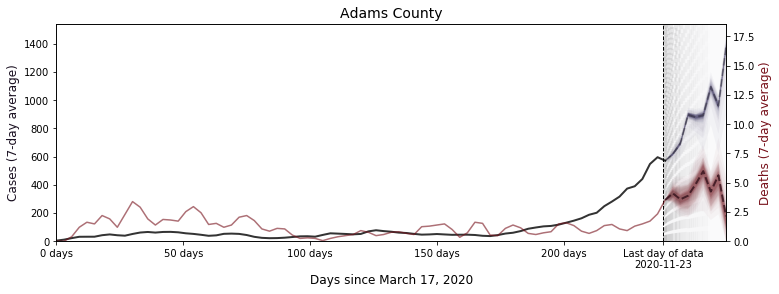

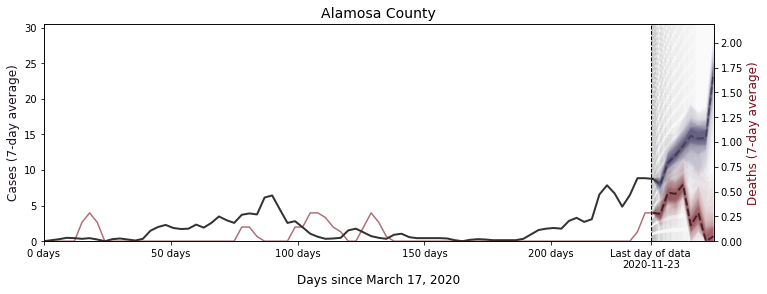

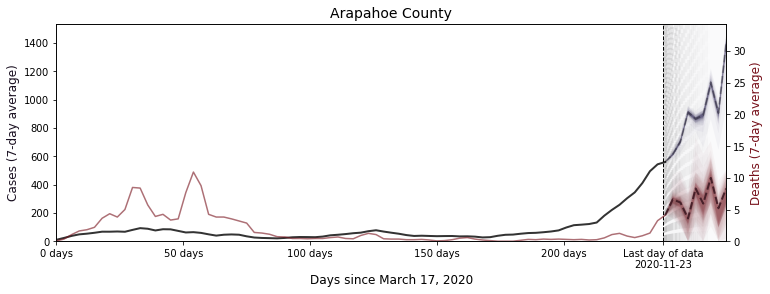

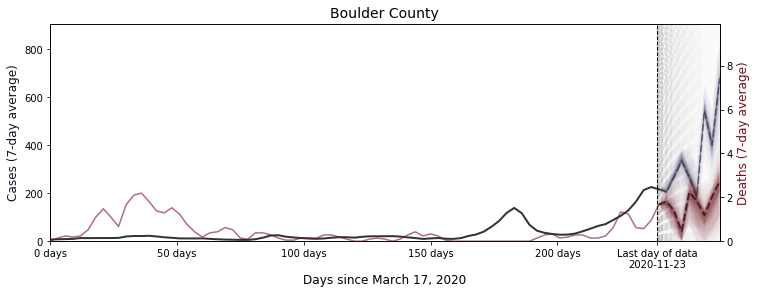

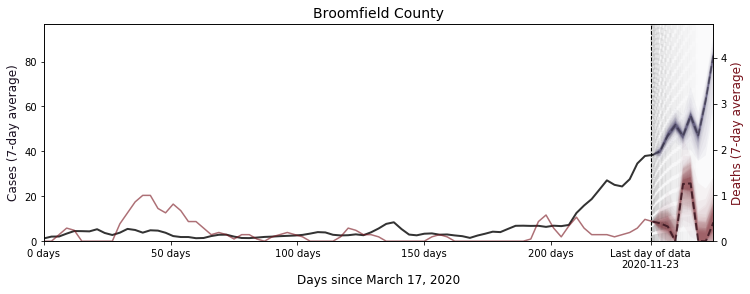

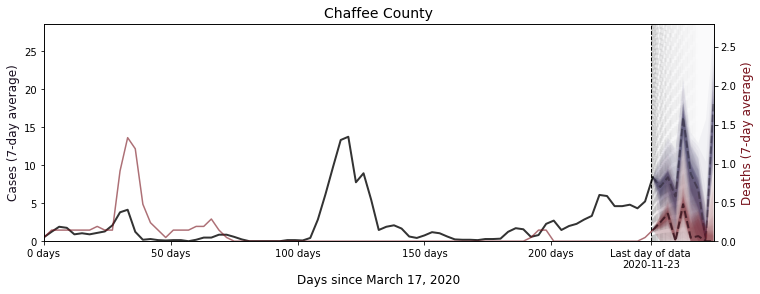

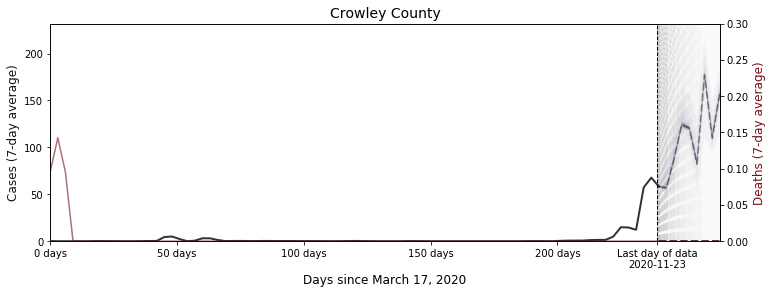

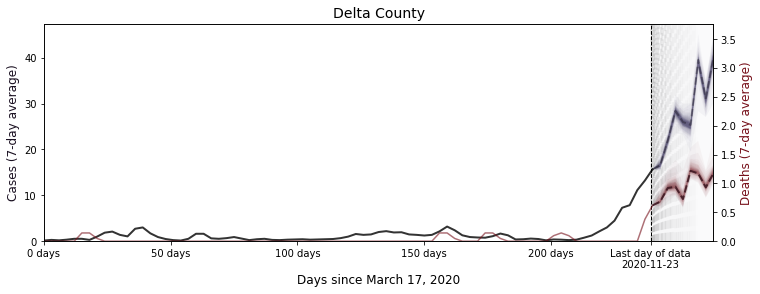

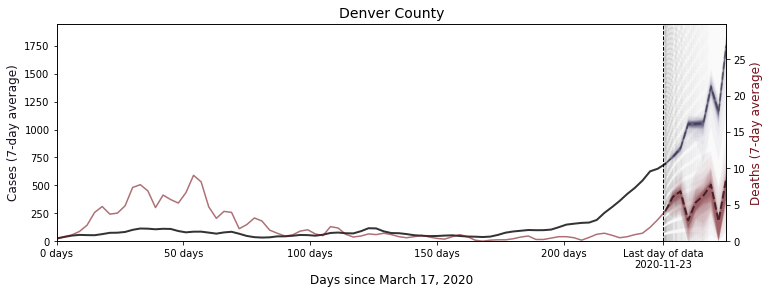

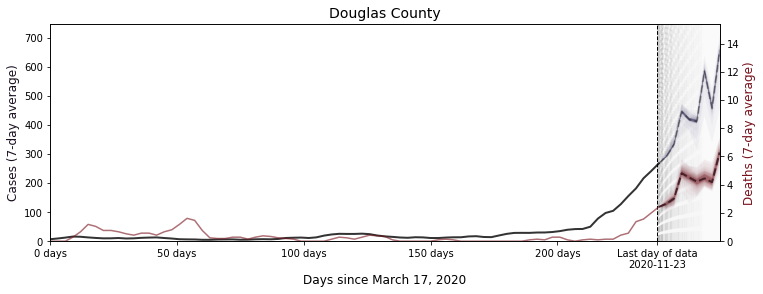

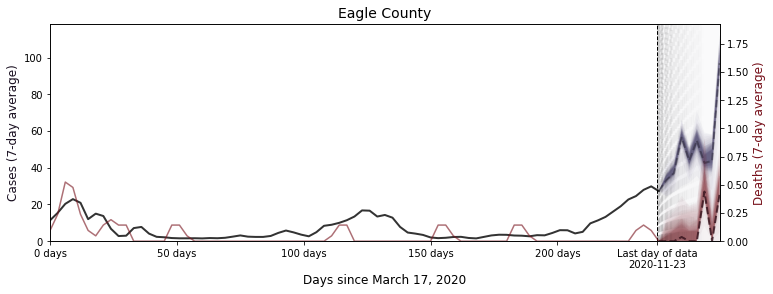

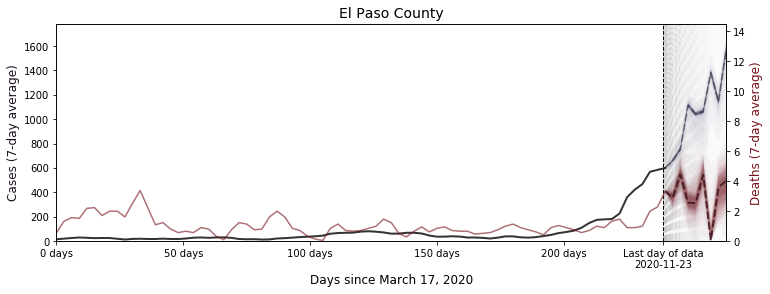

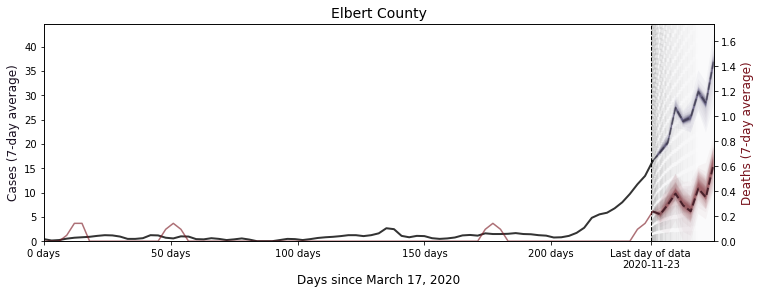

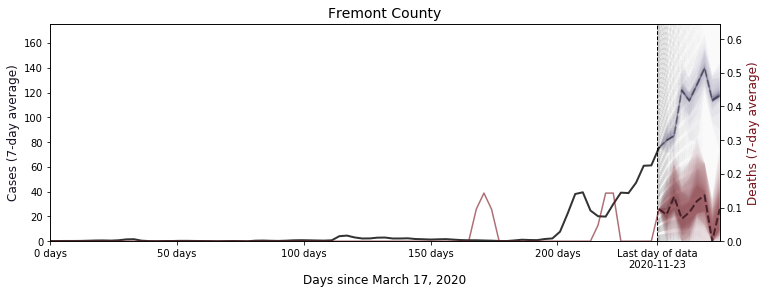

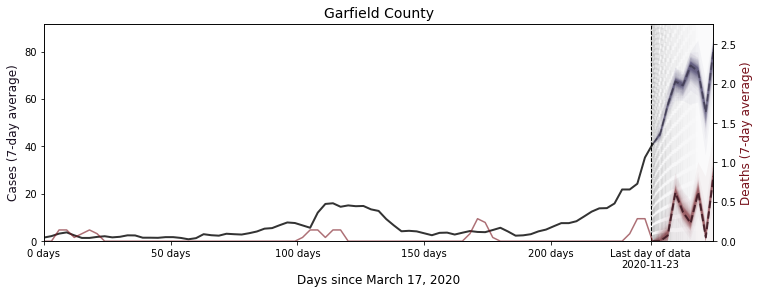

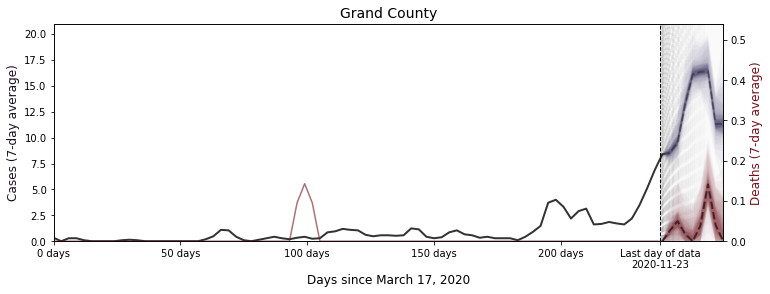

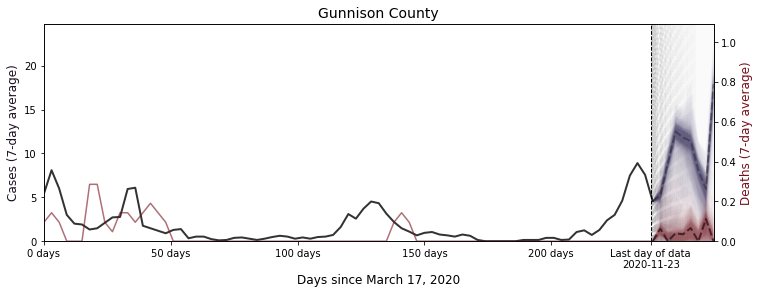

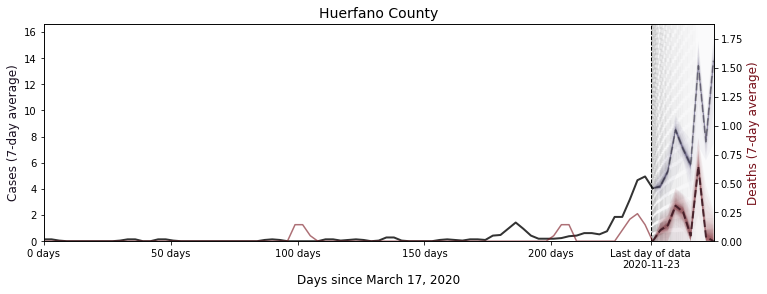

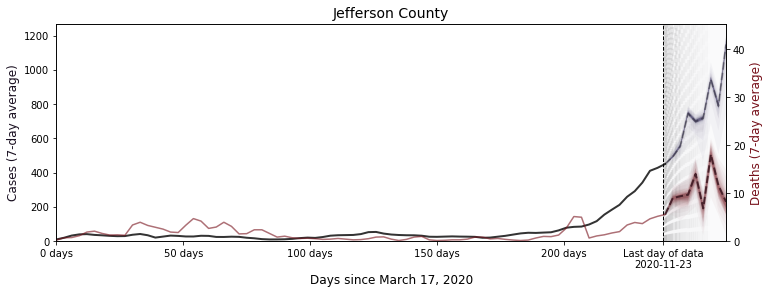

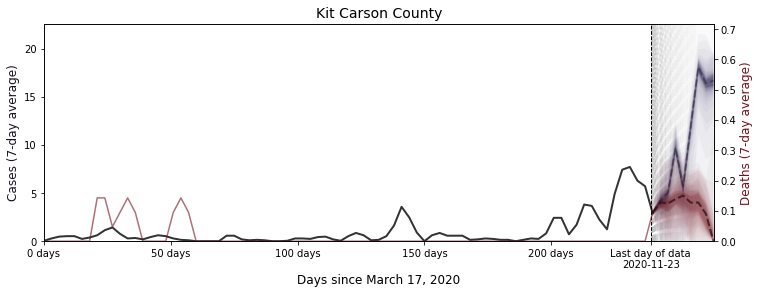

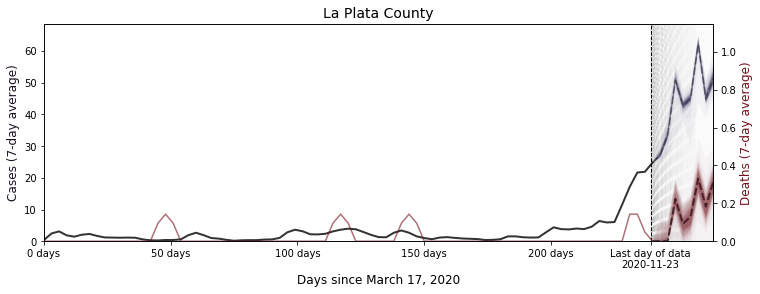

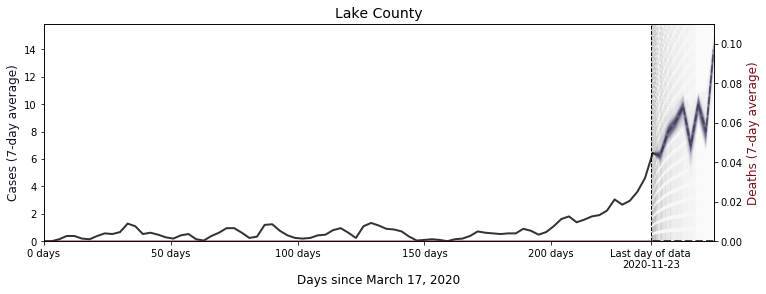

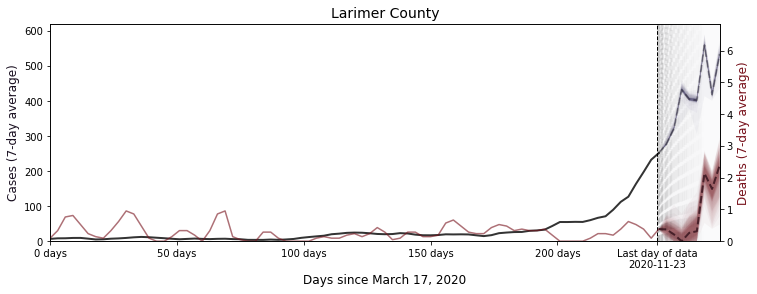

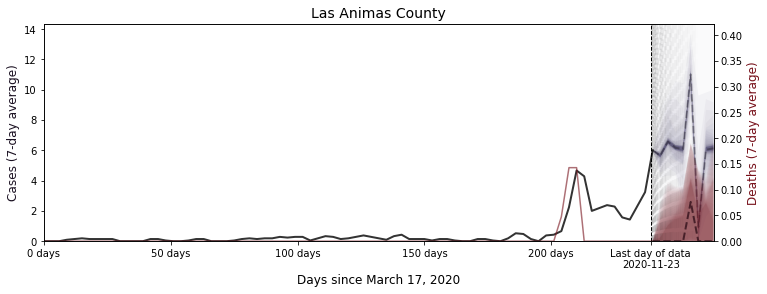

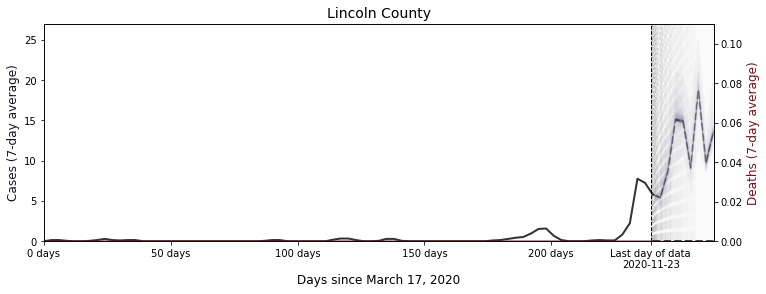

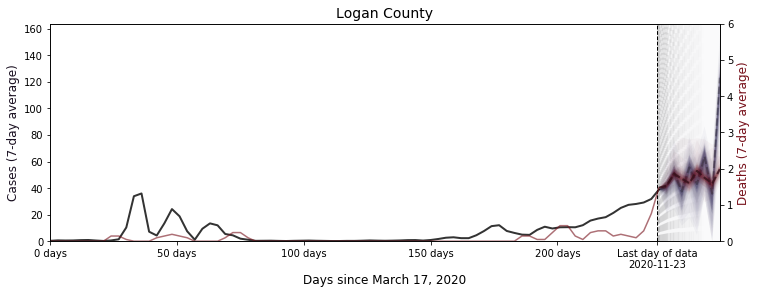

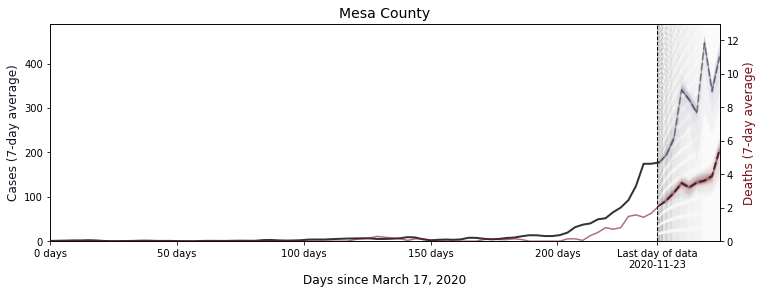

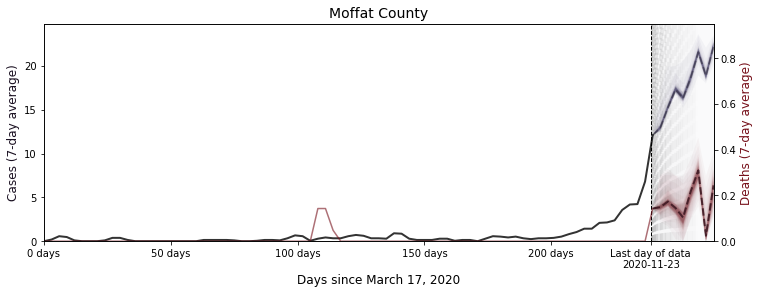

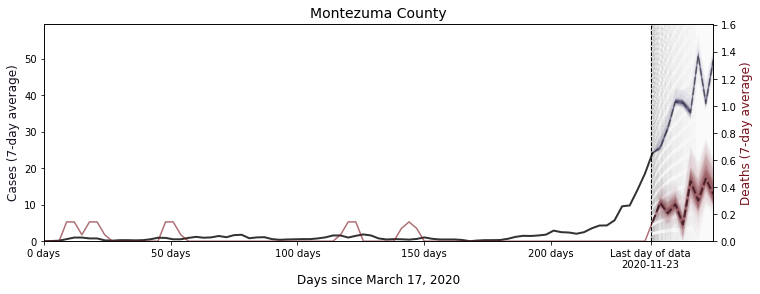

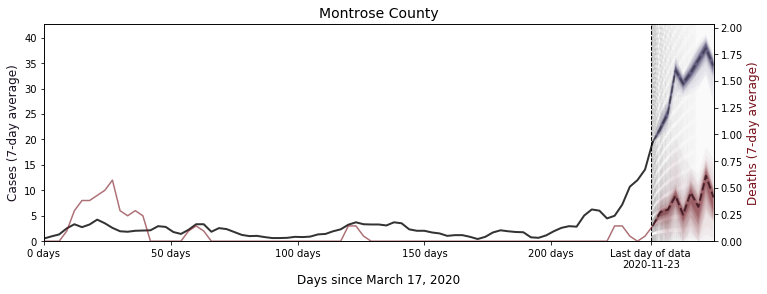

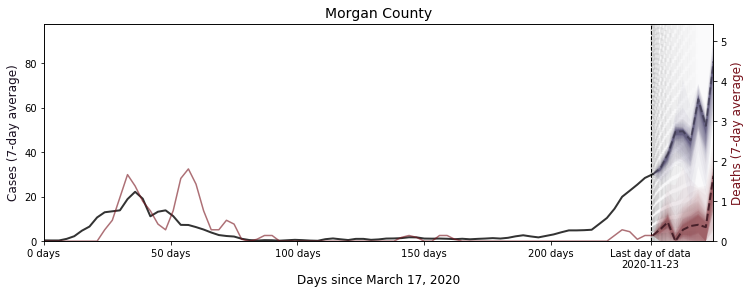

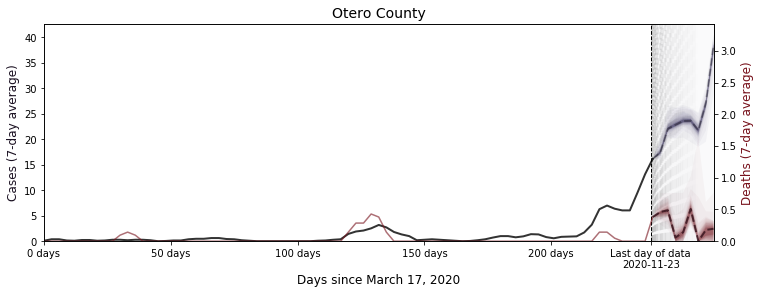

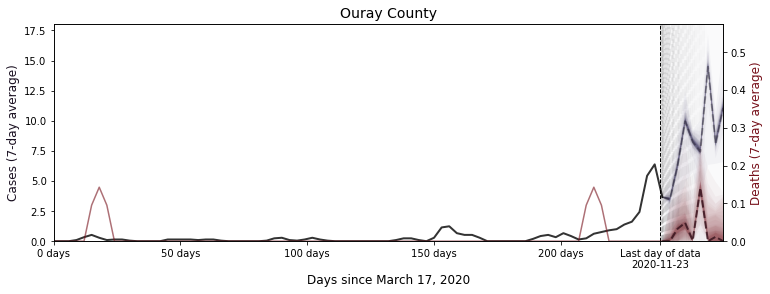

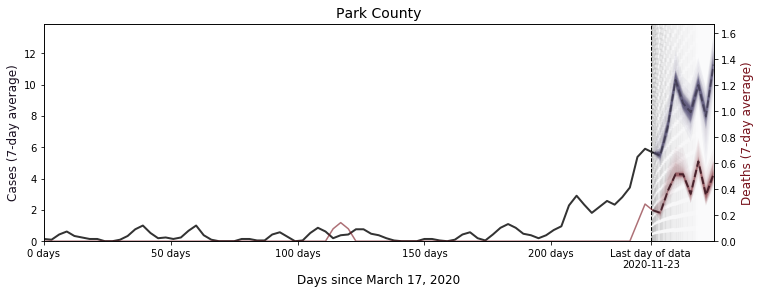

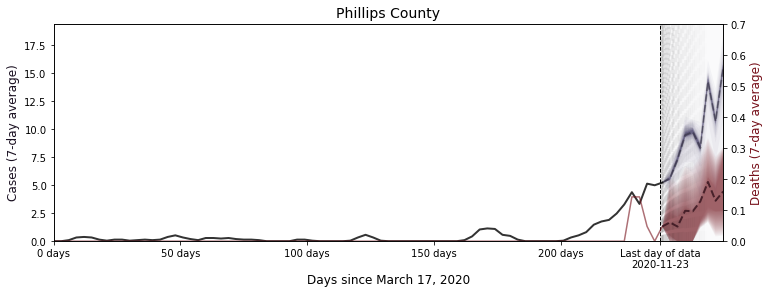

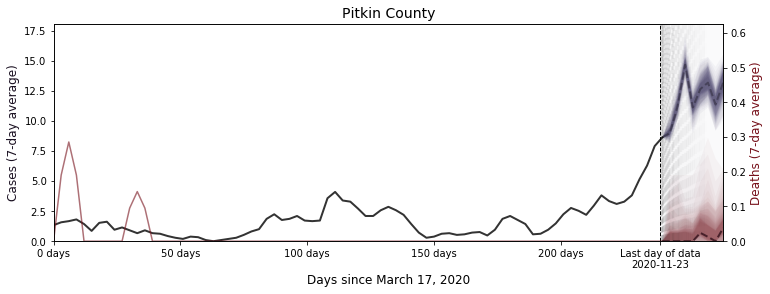

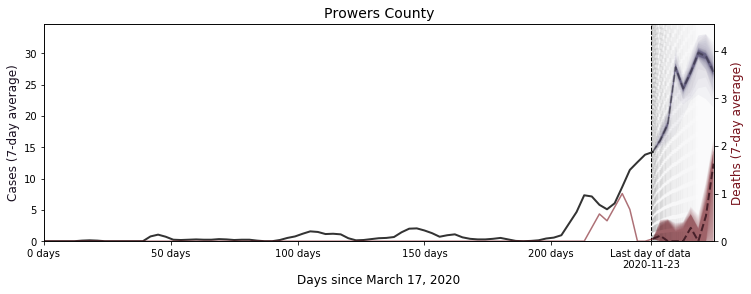

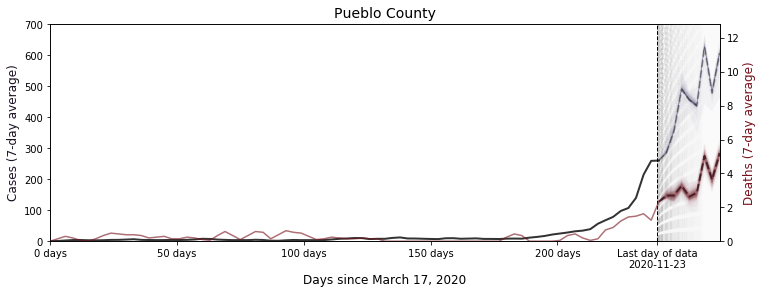

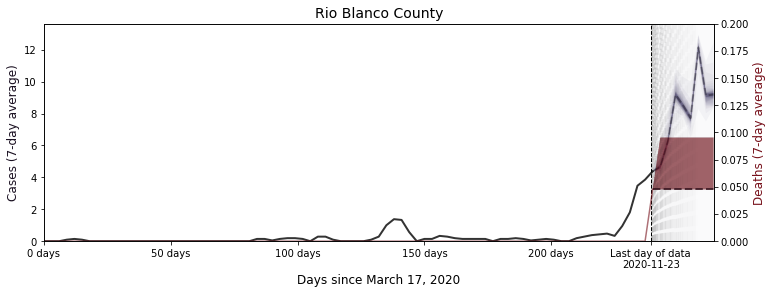

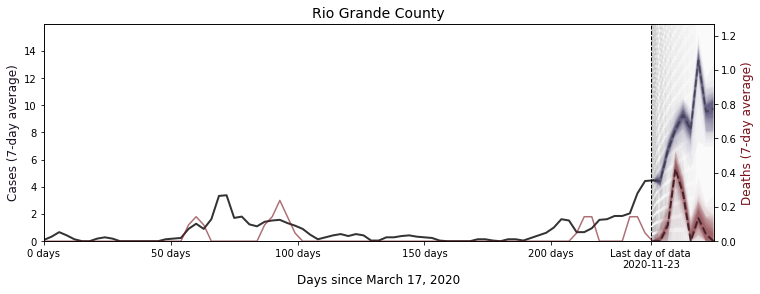

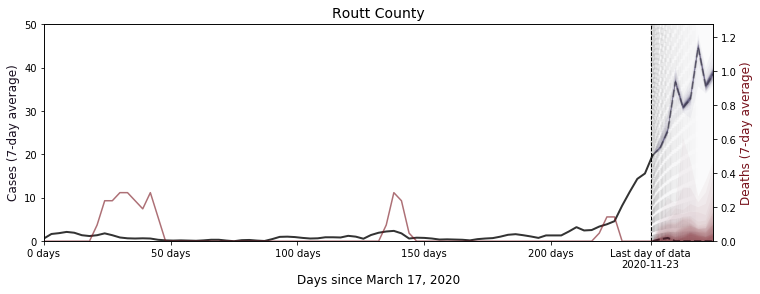

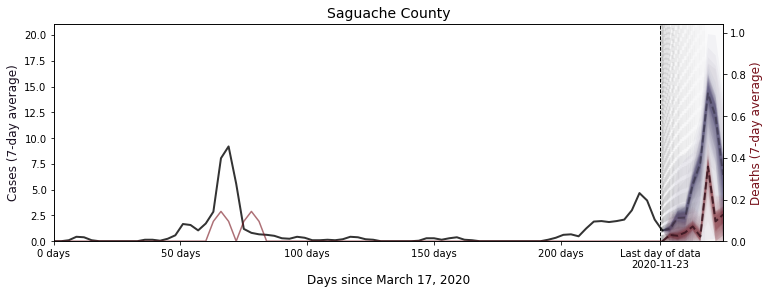

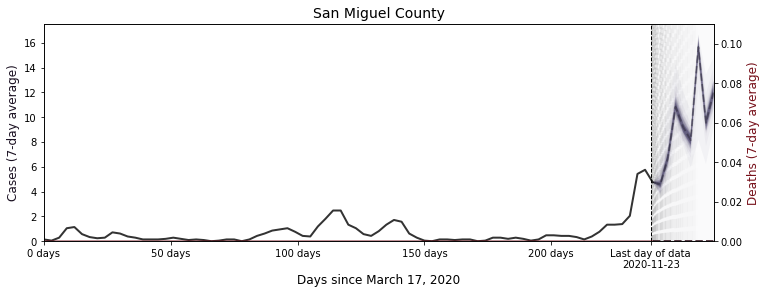

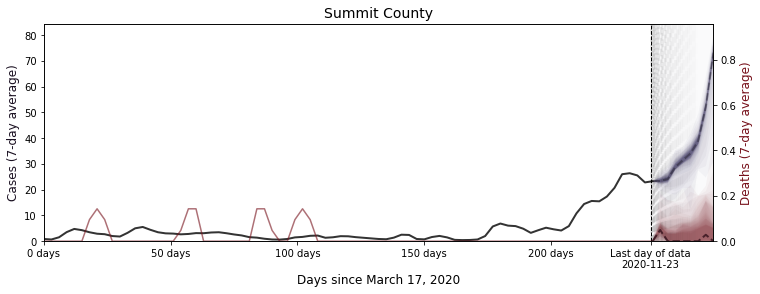

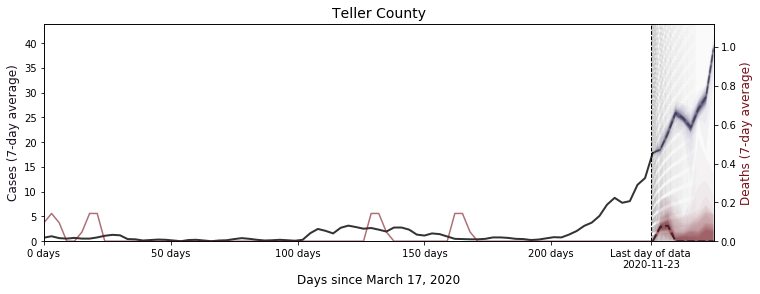

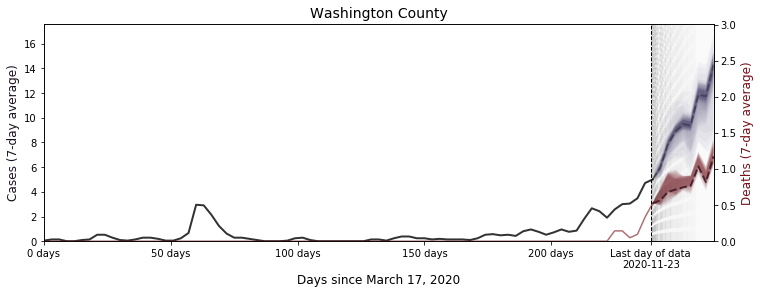

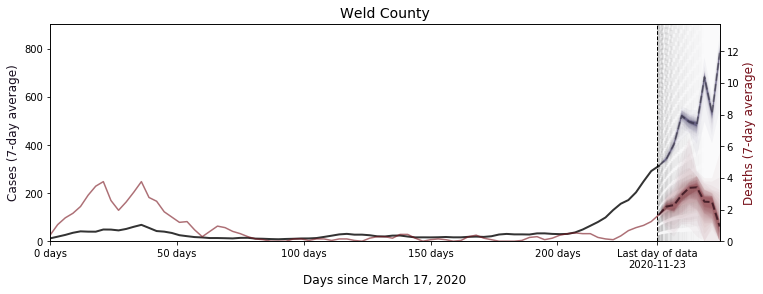

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# create error intervals

residuals_cases_lower = {}
residuals_cases_upper = {}
residuals_deaths_lower = {}
residuals_deaths_upper = {}

for r in range(30):
    residuals_cases_lower[r] = {}
    residuals_cases_upper[r] = {}
    residuals_deaths_lower[r] = {}
    residuals_deaths_upper[r] = {}
    
    lower = r * 1
    upper = 100 - lower

    for k in range(K):
        residuals_cases_lower[r][k] = {}
        residuals_cases_upper[r][k] = {}
        residuals_deaths_lower[r][k] = {}
        residuals_deaths_upper[r][k] = {}
        
        for county in counties:
            residuals_dist = np.array(residuals_cases[k][county])
            residuals_dist = residuals_dist[np.nonzero(residuals_dist)] # remove residuals that are exactly zero
                                                                        # (mostly the initial and future ones)
        
            if len(residuals_dist) > 0:
                residuals_cases_lower[r][k][county] = min(0, np.percentile(residuals_dist, lower))
                residuals_cases_upper[r][k][county] = max(0, np.percentile(residuals_dist, upper))
            else:
                residuals_cases_lower[r][k][county] = 0
                residuals_cases_upper[r][k][county] = 0
            
            #
            residuals_dist = np.array(residuals_deaths[k][county])
            residuals_dist = residuals_dist[np.nonzero(residuals_dist)]
        
            if len(residuals_dist) > 0:
                residuals_deaths_lower[r][k][county] = min(0, np.percentile(residuals_dist, lower))
                residuals_deaths_upper[r][k][county] = max(0, np.percentile(residuals_dist, upper))
            else:
                residuals_deaths_lower[r][k][county] = 0
                residuals_deaths_upper[r][k][county] = 0

# calculate things and plot them

# replace the original x values with 3*x (to convert 3-day windows to days)
def convert_xaxis(x):
    return [3*v for v in x]

for county in sorted(counties):
    values_cases = list(data_cases[county])
    values_deaths = list(data_deaths[county])
    Nv = len(values_cases)
    
    data_x = list(range(Nv))
    data_y_cases = list(values_cases)
    data_y_deaths = list(values_deaths)

    forecast_x = [Nv-1]
    forecast_y_cases = [values_cases[-1]]
    forecast_y_deaths = [values_deaths[-1]]
    
    forecast_y_cases_lower = {}
    forecast_y_cases_upper = {}
    forecast_y_deaths_lower = {}
    forecast_y_deaths_upper = {}
    for r in range(50):
        forecast_y_cases_lower[r] = [values_cases[-1]]
        forecast_y_cases_upper[r] = [values_cases[-1]]
        forecast_y_deaths_lower[r] = [values_deaths[-1]]
        forecast_y_deaths_upper[r] = [values_deaths[-1]]
    
    for k in range(K):
        M = len(models_cases[k][county]) - 1
        
        # cases

        predicted_diff = models_cases[k][county][M].predict([features_scaled[k][M]])[0]
        predicted = max(0, values_cases[-1] + predicted_diff) # undo differencing from final value

        forecast_x.append(Nv+k)
        forecast_y_cases.append(predicted)
        
        for r in range(30):
            forecast_y_cases_lower[r].append(max(0, predicted+residuals_cases_lower[r][k][county]))
            forecast_y_cases_upper[r].append(max(0, predicted+residuals_cases_upper[r][k][county]))

        # deaths
        predicted_diff = models_deaths[k][county][M].predict([features_scaled[k][M]])[0]
        predicted = max(0, values_deaths[-1] + predicted_diff) # undo differencing from final value

        forecast_y_deaths.append(predicted)
        
        for r in range(30):
            forecast_y_deaths_lower[r].append(max(0, predicted+residuals_deaths_lower[r][k][county]))
            forecast_y_deaths_upper[r].append(max(0, predicted+residuals_deaths_upper[r][k][county]))

    max_value_cases = max(data_y_cases + forecast_y_cases)
    max_value_deaths = max(data_y_deaths + forecast_y_deaths)
    
    if max_value_cases >= 10:   # Skip counties with low values; set to 0 if you want them all
        plt.rcParams['figure.figsize'] = [12, 4]
        fig, ax1 = plt.subplots()
        
        ax1.set_ylabel('Cases (7-day average)', color='#1b1122', size=12)
        ax1.plot(convert_xaxis(data_x), data_y_cases, 'k-', alpha=0.8, linewidth=2)
        ax1.plot(convert_xaxis(forecast_x), forecast_y_cases, 'k--', alpha=0.3, linewidth=2)
        
        for r in range(30):
            ax1.fill_between(convert_xaxis(forecast_x), forecast_y_cases_lower[r], forecast_y_cases_upper[r], \
                             facecolor='#1b1149', alpha=0.03)
        
        ax2 = ax1.twinx()
        ax2.set_ylabel('Deaths (7-day average)', color='#77111b', size=12)
        ax2.plot(convert_xaxis(data_x), data_y_deaths, color='#77111b', alpha=0.6, linewidth=1.5)
        ax2.plot(convert_xaxis(forecast_x), forecast_y_deaths, '--', color='#33111b', alpha=0.8, linewidth=2)
        
        for r in range(30):
            ax2.fill_between(convert_xaxis(forecast_x), forecast_y_deaths_lower[r], forecast_y_deaths_upper[r], \
                             facecolor='#77111b', alpha=0.03)
        
        # make it all a little gray
        
        ymax = 2 * ax2.get_ylim()[1] # make deaths take up less visual space by doubling the y range
        
        plt.fill_between(convert_xaxis(forecast_x), 0, ymax, facecolor='#1b1149', alpha=0.02) 
        plt.vlines(convert_xaxis([Nv-1.25]), 0, ymax, linestyles='dashed', linewidth=1.0, alpha=1.0)
        
        xi = Nv - 1.2
        for i in range(30):
            a0 = 0.1
            a = a0 - (i * (a0/30))
            xi += 0.05 + (0.01 * i)
            
            l = 1.5 + (0.05 * i)
            plt.vlines(convert_xaxis([xi]), 0, ymax, linestyles='dashed', linewidth=l, alpha=a)
            
        plt.fill_between(convert_xaxis([Nv-1.2,xi]), 0, ymax, facecolor='#1b1149', alpha=0.01) 
        
        # label the date when the forecast begins
        
        old_xticks = list(ax1.get_xticks())
        xticks = []
        xlabels = []
        for xtick in old_xticks:
            if xtick >= 0 and xtick < convert_xaxis([Nv-10])[0]:
                xticks.append(xtick)
                xlabels.append('%d days' % xtick)
        
        xticks.append(convert_xaxis([Nv-1.25])[0])
        xlabels.append('Last day of data\n%s' % final_date)
        
        ax1.set_xticks(xticks)
        ax1.set_xticklabels(xlabels)
        
        # finalize
        Nx = convert_xaxis(forecast_x)[-1]
        ax1.set_xlabel('Days since March 17, 2020', size=12)
        ax1.set_ylim(bottom=0)
        ax1.set_xlim([0, Nx])
        ax2.set_ylim([0, ymax])
        plt.title('%s County' % county, size=14)
        
        plt.show()
        
        #break